# Autoencoder for uninfected malaria cell images

## Imports

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, LeakyReLU
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Data Preparation

In [2]:
RANDOM_STATE = 7
BASE_PATH = "/Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Uninfected"
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 64
SIZE  = 64

### Training

### Callbacks

### Saving

In [3]:
PLOTS_DPI = 200
MODEL_NAME = 'Autoencoder_Reconstruction'
PLOTS_DIR = os.path.join('plots', MODEL_NAME)
TB_LOGS = "tensorboard_logs/Autoencoder_Reconstruction/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Data Loading

In [4]:
os.path.join(BASE_PATH, '*.png')

'/Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Uninfected/*.png'

In [5]:
''' It returns:
Since the Folders with the images have the following structure:
- ROOT
-- Parasitized
-- Uninfected
I need to construct the corrisponding label
'''
images_dir_path = '/Users/simoneboesso/Desktop/nuclei-segmentation/cell_images'  
images_dirs_paths = [name for name in os.listdir(images_dir_path) if name != '.DS_Store']
image_paths = []
image_classes = []
class_id = 0

def imglist(path_dir):    
    return [os.path.join(path_dir, image) for image in os.listdir(path_dir)]

''' It returns:
- image_paths: list of paths to all the images
- image_classes: list of labels
'''
for images_dir in images_dirs_paths:
    if images_dir  == "Parasitized":
        class_id = 1
    else:
        class_id = 0
    sub_dir = os.path.join(images_dir_path, images_dir)
    class_path = imglist(sub_dir)
    image_paths+=class_path
    image_classes+=[class_id]*len(class_path)
    class_id+=1

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras
import random
import pandas as pd
import tensorflow

In [7]:
image_data = []
labels = []

index = 0
for image_path in image_paths:
    if '.png' in image_path:
        image = cv2.imread(image_path)
        if image is not None:
            # Convert to RGB using PIL
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            # Resize the image
            image = image.resize((SIZE, SIZE))
            normalized_image = np.array(image) / 255.0
            image_data.append(normalized_image)
            labels.append(image_classes[index])
        else:
            print(f"Image {image_path} could not be loaded")
    else:
        print(f"Image {image_path} is not a PNG file")
    index += 1

Image /Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Parasitized/Thumbs.db is not a PNG file
Image /Users/simoneboesso/Desktop/nuclei-segmentation/cell_images/Uninfected/Thumbs.db is not a PNG file


In [8]:
image_data[0].max()

0.9333333333333333

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(np.array(image_data), to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(np.array(image_data), to_categorical(np.array(labels)), test_size = 0.20, random_state = 0)

In [11]:
mask = (y_train[:,0]==0)
X_train = X_train[mask]

In [12]:
X_train.shape

(11076, 64, 64, 3)

In [13]:
mask = (y_val[:,0]==0)
X_val_healthy = X_val[mask]

## Model Creation

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

In [54]:

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, BatchNormalization
from tensorflow.keras.models import Model

input_img = Input(shape=(64, 64, 3))
# Encoder
x = Conv2D(16, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)

encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3),padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)

x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)





# Define a learning rate schedule function
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 2.0
    return float(lr)  # Ensure the returned value is a float

# Compile the model with an initial learning rate
initial_learning_rate = 0.0001
optimizer = Adam(learning_rate=initial_learning_rate)
autoencoder.compile(optimizer=optimizer, loss=MeanAbsoluteError())

# Create a callback for the learning rate scheduler
lr_callback = LearningRateScheduler(scheduler, verbose=1)

In [55]:
autoencoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 64, 64, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 32, 32, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 32, 32, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 8, 8, 8)        │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 8, 8, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_24 (UpSampling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 16, 16, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_25 (UpSampling2D) │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,219 (20.39 KB)

 Trainable params: 5,091 (19.89 KB)

 Non-trainable params: 128 (512.00 B)

### Model compilation

In [56]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('Autoencoder_for_Denoising.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'), lr_callback ]

In [ ]:
import tensorflow
import numpy as np
#Fit the model
history = autoencoder.fit(np.array(X_train), 
                         X_train, 
                         batch_size = 128, 
                         verbose = 1, 
                         epochs = 100,      
                          validation_data=(X_val_healthy , X_val_healthy ),
                         shuffle = False,
                         callbacks= callbacks
                     )

In [76]:
import numpy as np
from sklearn.metrics import f1_score
y_val2= np.argmax(y_val, axis=1)

reconstructed_X = autoencoder.predict(X_val)
# Calculate mean squared error (MSE) for each point in the test set
mse = np.mean(np.power(X_val - reconstructed_X,2), axis=(1,2,3))

# Initialize variables to store the best threshold and F1 score
best_threshold = None
best_f1 = 0
print(mse)
# Test a range of possible threshold values
for threshold in np.linspace(min(mse), max(mse), num=1000):
    # Predict anomalies where MSE is greater than the threshold
    predictions = (mse > threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val2, predictions)
    
    # Update the best threshold if the current F1 score is better
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1}")


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
[0.00585121 0.00727547 0.00469259 ... 0.01016374 0.00651062 0.00601832]
Best Threshold: 0.0062565647177809085
Best F1 Score: 0.7224602203182374


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

y_test2= np.argmax(y_test, axis=1)
threshold = best_threshold
reconstructed_X = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_X, 2), axis=(1,2,3))
predictions = (mse > threshold).astype(int)
f1 = f1_score(y_test2, predictions)

# Assuming y_test2 contains the true labels and predictions contains the predicted labels
accuracy = accuracy_score(y_test2, predictions)
precision = precision_score(y_test2, predictions, average='binary')  # Use 'binary' for binary classification
recall = recall_score(y_test2, predictions, average='binary')  # Use 'binary' for binary classification

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print("f1 ",f1)
print("recall",recall)

173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Accuracy: 0.670899854862119
Precision: 0.615966605791808
f1  0.7224602203182374
recall 0.8734739178690344


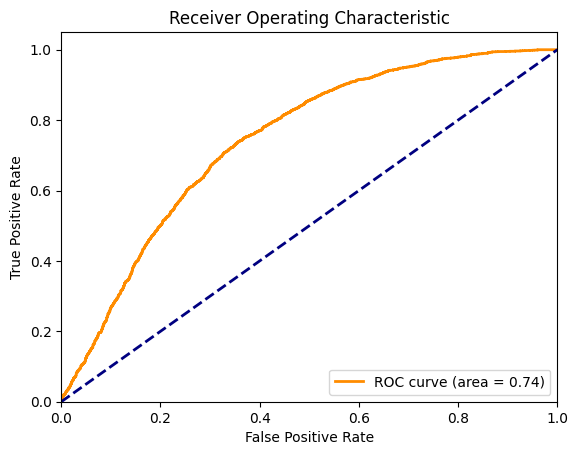

In [84]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test2, mse)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Model Loss over Epochs

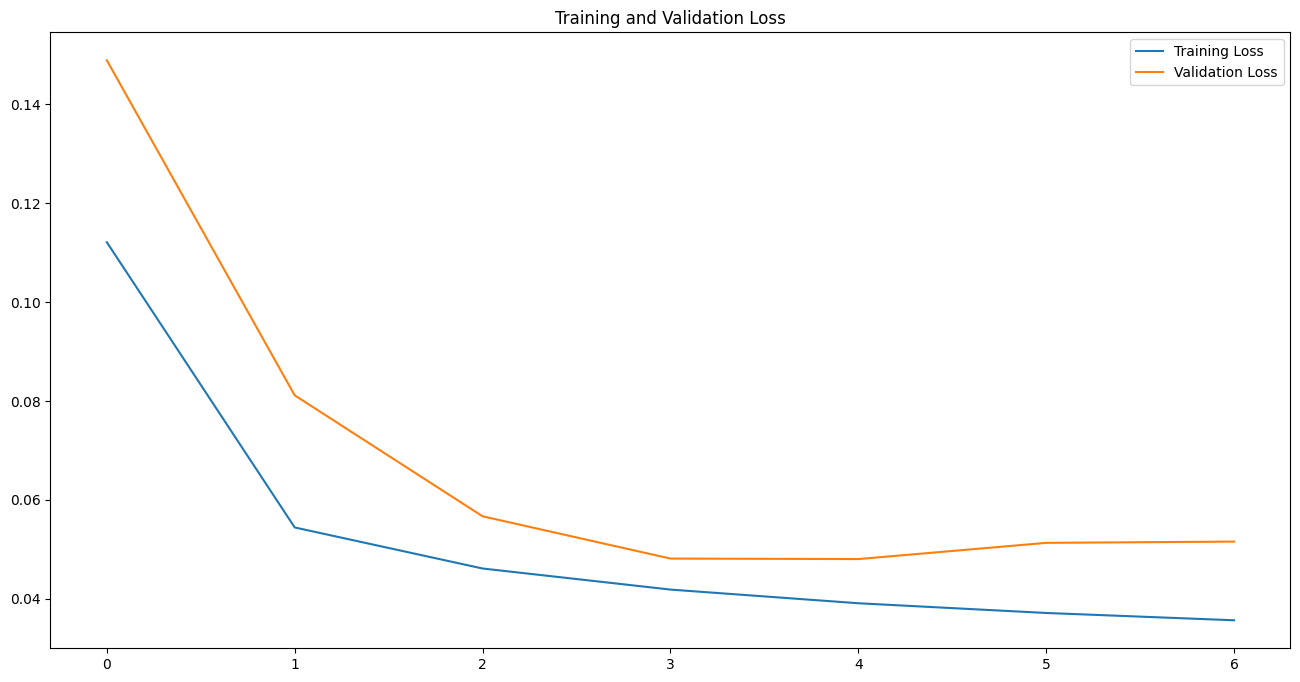

In [85]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()